In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from collections import Counter
import os

# Modeling Libraries
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split

In [3]:
# Loding dataset
df = pd.read_csv("diabetes.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.shape

(768, 9)

In [6]:
# Exploring missing values
missing_values_count = df.isnull().sum()
print("count of missing values:\n",missing_values_count)

count of missing values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [7]:
# Correcting missing values in Glucose
df['Glucose'] = df['Glucose'].replace(0, df['Glucose'].mean())
# Correcting missing values in blood pressure
df['BloodPressure'] = df['BloodPressure'].replace(0, df['BloodPressure'].mean()) # There are 35 records with 0 BloodPressure in dataset
# Correcting missing values in BMI
df['BMI'] = df['BMI'].replace(0, df['BMI'].median())
# Correct missing values in Insulin and SkinThickness

df['SkinThickness'] = df['SkinThickness'].replace(0, df['SkinThickness'].median())
df['Insulin'] = df['Insulin'].replace(0, df['Insulin'].median())

In [8]:
# Reviewing dataset statistics
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<Axes: >

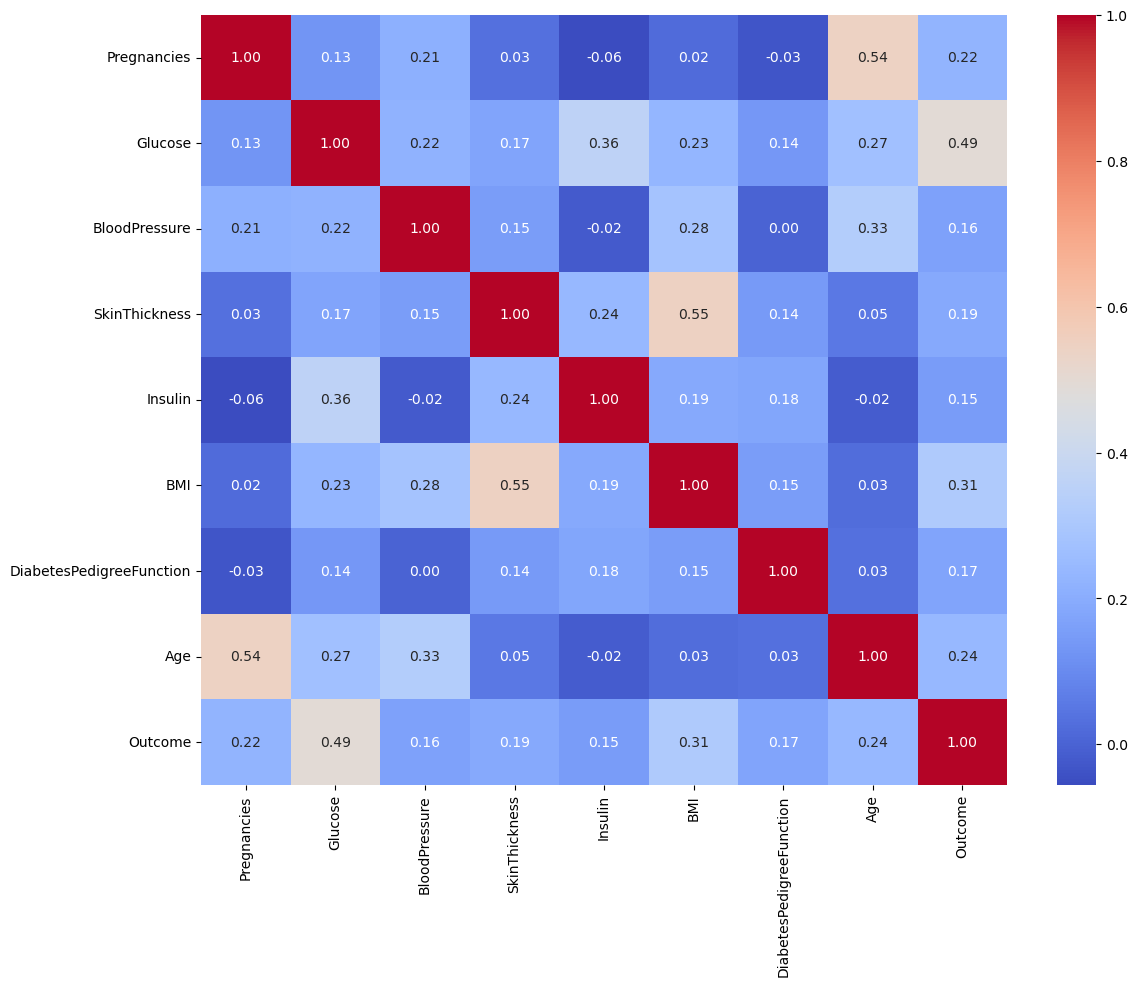

In [9]:
#Correlation
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

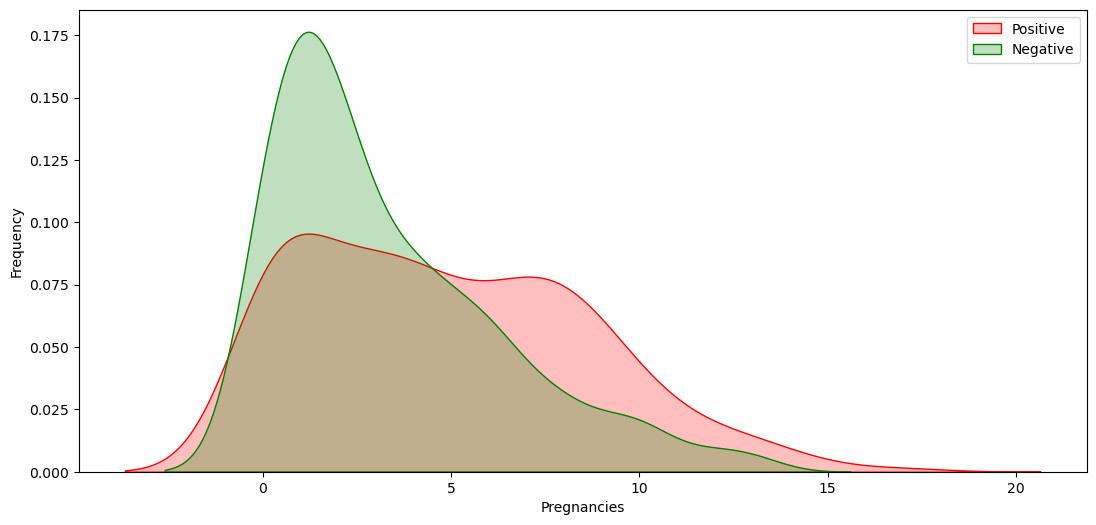

In [10]:
# Exploring Pregnancies vs Outcome
plt.figure(figsize=(13,6))
g = sns.kdeplot(df["Pregnancies"][df["Outcome"] == 1], 
     color="Red", shade = True)
g = sns.kdeplot(df["Pregnancies"][df["Outcome"] == 0], 
     ax =g, color="Green", shade= True)
g.set_xlabel("Pregnancies")
g.set_ylabel("Frequency")
g.legend(["Positive","Negative"])

<Axes: xlabel='Outcome', ylabel='count'>

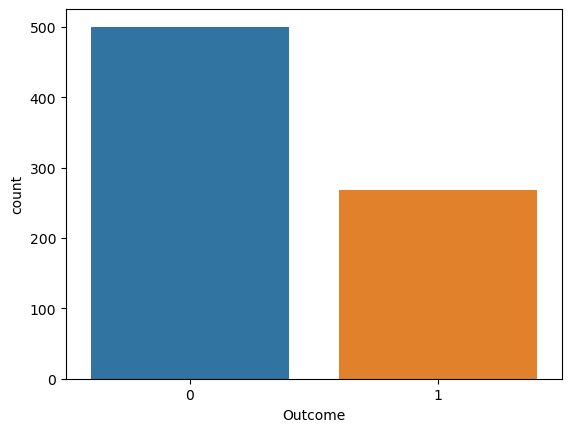

In [11]:
#data visualization
sns.countplot(x='Outcome', data = df)

<Axes: xlabel='Outcome', ylabel='Glucose'>

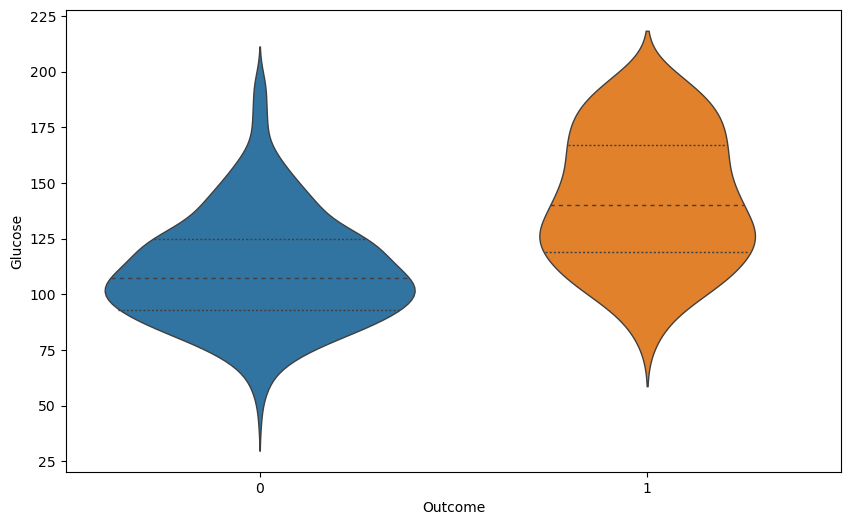

In [12]:
# Exploring Gluecose vs Outcome
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x="Outcome", y="Glucose",
               split=True, inner="quart", linewidth=1)

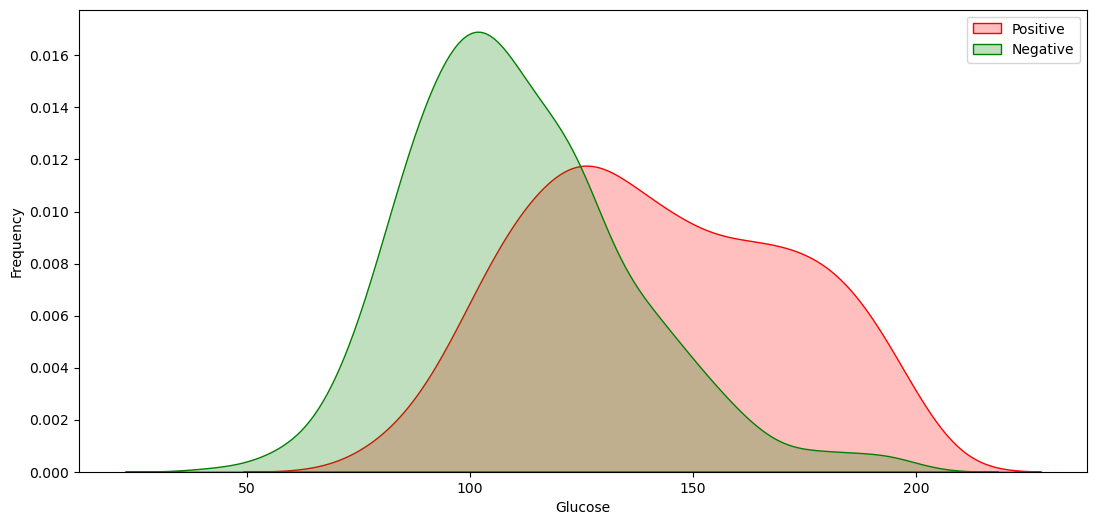

In [13]:
# Exploring Glucose vs Outcome

plt.figure(figsize=(13,6))
g = sns.kdeplot(df["Glucose"][df["Outcome"] == 1], color="Red", shade = True)
g = sns.kdeplot(df["Glucose"][df["Outcome"] == 0], ax =g, color="Green", shade= True)
g.set_xlabel("Glucose")
g.set_ylabel("Frequency")
g.legend(["Positive","Negative"])

<Axes: xlabel='Glucose', ylabel='BMI'>

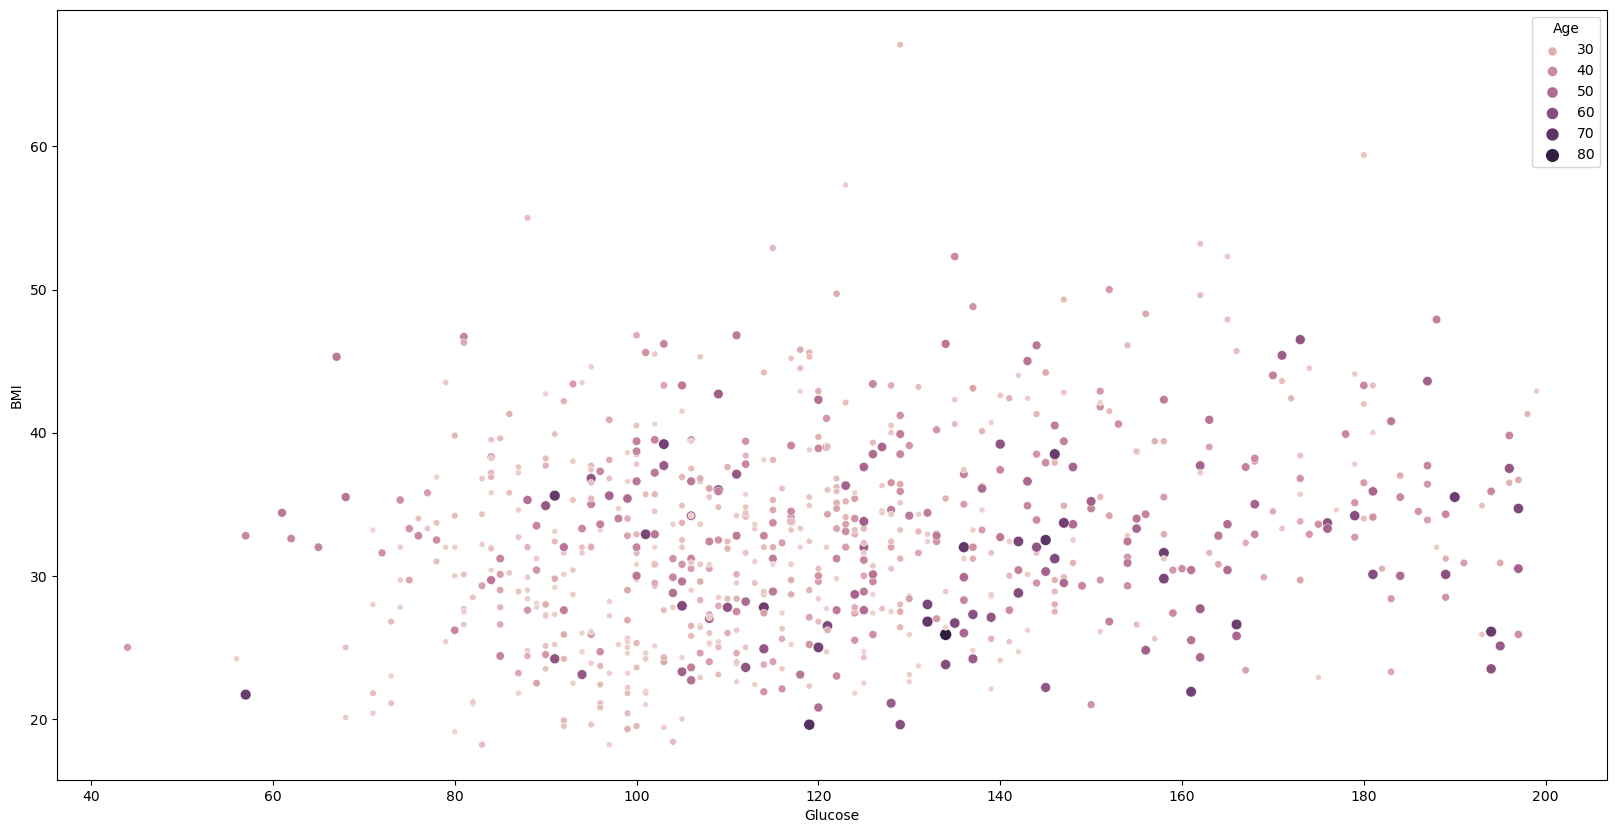

In [14]:
# Glucose vs BMI vs Age

plt.figure(figsize=(20,10))
sns.scatterplot(data=df, x="Glucose", y="BMI", hue="Age", size="Age")

In [15]:
def detect_outliers(df,n,features):
    outlier_indices = []
    """
    Detect outliers from given list of features. It returns a list of the indices
    according to the observations containing more than n outliers according
    to the Tukey method
    """
    # iterate over features(columns)
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # appending the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # selectting observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detecting outliers from numeric features
outliers_to_drop = detect_outliers(df, 2 ,["Pregnancies", 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'SkinThickness', 'Insulin', 'Age'])
df.drop(df.loc[outliers_to_drop].index, inplace=True)

In [16]:
# Data Transformation
q  = QuantileTransformer()
X = q.fit_transform(df)
transformedDF = q.transform(X)
transformedDF = pd.DataFrame(X)
transformedDF.columns =['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
# Showing top 5 rows
transformedDF.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.746728,0.812173,0.518979,0.804974,0.255890,0.593586,0.752618,0.889398,1.0
1,0.230366,0.091623,0.290576,0.645942,0.255890,0.214005,0.476440,0.556937,0.0
2,0.863220,0.956806,0.234293,0.358639,0.255890,0.077880,0.784031,0.582461,1.0
3,0.230366,0.125654,0.290576,0.358639,0.662958,0.285340,0.106675,0.000000,0.0
4,0.000000,0.723168,0.005236,0.804974,0.834424,0.929319,0.998691,0.604712,1.0


In [17]:
# Data Splitting
features = df.drop(["Outcome"], axis=1)
labels = df["Outcome"]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=7)

In [18]:
def evaluate_model(models):
    """
    Takes a list of models and returns chart of cross validation scores using mean accuracy
    """
    
    # Cross validate model with Kfold stratified cross val
    kfold = StratifiedKFold(n_splits = 10)
    
    result = []
    for model in models :
        result.append(cross_val_score(estimator = model, X = x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

    cv_means = []
    cv_std = []
    for cv_result in result:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    result_df = pd.DataFrame({
        "CrossValMeans":cv_means,
        "CrossValerrors": cv_std,
        "Models":[
            "LogisticRegression",
            "SVC",
            "RandomForestClassifier",
            "GradientBoostingClassifier",
            "MLPClassifier"
        ] 
    })

    # Generate chart
    bar = sns.barplot(x = "CrossValMeans", y = "Models", data =
result_df, orient = "h")
    bar.set_xlabel("Mean Accuracy")
    bar.set_title("Cross validation scores")
    return result_df

,CrossValMeans,CrossValerrors,Models
0,0.747869,0.069754,LogisticRegression
1,0.760901,0.050156,SVC
2,0.762893,0.061561,RandomForestClassifier
3,0.751747,0.098608,GradientBoostingClassifier
4,0.716143,0.058155,MLPClassifier


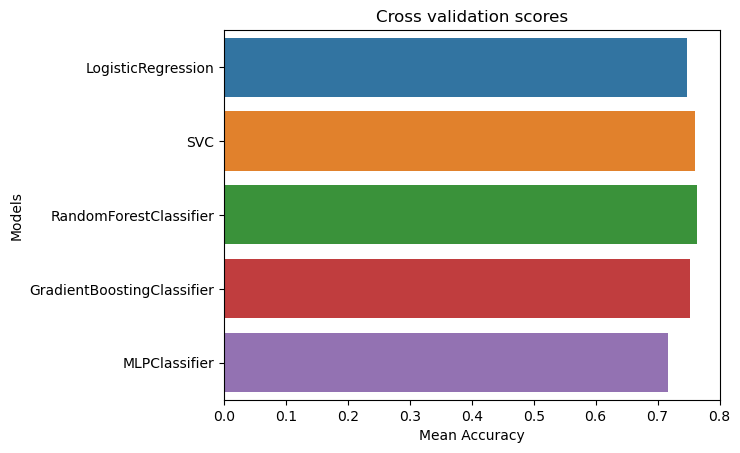

In [19]:
# Modeling step Test differents algorithms 
random_state = 30
models = [
    LogisticRegression(random_state = random_state, solver='liblinear'),
    SVC(random_state = random_state),
    RandomForestClassifier(random_state = random_state),
    GradientBoostingClassifier(random_state = random_state),
    MLPClassifier(),
]     
evaluate_model(models)

In [20]:
# GridSearchCV

def analyze_grid_result(grid_result):
    '''
    Analysis of GridCV result and predicting with test dataset
    Show classification report at last
    '''
    # Best parameters and accuracy
    print("Tuned hyperparameters: (best parameters) ", grid_result.best_params_)
    print("Accuracy :", grid_result.best_score_)
    
    means = grid_result.cv_results_["mean_test_score"]
    stds = grid_result.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, grid_result.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    y_true, y_pred = y_test, grid_result.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

In [21]:
# Define models and parameters for LogisticRegression
model = LogisticRegression(solver='liblinear')
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Define grid search
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = StratifiedKFold(n_splits = 50, random_state = 1, shuffle = True)
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = cv, scoring = 'accuracy', error_score = 0)
logi_result = grid_search.fit(x_train, y_train)

# Logistic Regression Hyperparameter Result
analyze_grid_result(logi_result)



Tuned hyperparameters: (best parameters)  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 0.7883636363636363
0.788 (+/-0.260) for {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.788 (+/-0.260) for {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.788 (+/-0.260) for {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.788 (+/-0.250) for {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.785 (+/-0.253) for {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.745 (+/-0.266) for {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.773 (+/-0.238) for {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.705 (+/-0.281) for {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.773 (+/-0.232) for {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.696 (+/-0.264) for {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

Detailed classification report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       147
           1    

In [22]:
# Define models and parameters for Support Vector
model = SVC()
# Define grid search
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]
cv = StratifiedKFold(n_splits = 2, random_state = 1, shuffle = True)
grid_search = GridSearchCV(estimator = model, param_grid = tuned_parameters, cv = cv, scoring = 'accuracy', error_score = 0)
SVC_result = grid_search.fit(x_train, y_train)
# SVC Hyperparameter Result
analyze_grid_result(SVC_result)

Tuned hyperparameters: (best parameters)  {'C': 10, 'kernel': 'linear'}
Accuracy : 0.7775797976410084
0.712 (+/-0.061) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.735 (+/-0.053) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.677 (+/-0.035) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.716 (+/-0.016) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.658 (+/-0.020) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.707 (+/-0.042) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.656 (+/-0.001) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.667 (+/-0.046) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.770 (+/-0.025) for {'C': 1, 'kernel': 'linear'}
0.778 (+/-0.010) for {'C': 10, 'kernel': 'linear'}
0.778 (+/-0.005) for {'C': 100, 'kernel': 'linear'}
0.744 (+/-0.005) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       147
           1       0.67      0

In [23]:
# Define models and parameters for  RandomForest
model = RandomForestClassifier(random_state=42)
# Define grid search
tuned_parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
cv = StratifiedKFold(n_splits = 2, random_state = 1, shuffle = True)
grid_search = GridSearchCV(estimator = model, param_grid = tuned_parameters, cv = cv, scoring = 'accuracy', error_score = 0)
RF_result = grid_search.fit(x_train, y_train)
# RandomForest Hyperparameter Result
analyze_grid_result(RF_result)

Tuned hyperparameters: (best parameters)  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}
Accuracy : 0.7663648051875454
0.759 (+/-0.025) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}
0.761 (+/-0.029) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
0.759 (+/-0.025) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}
0.761 (+/-0.029) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}
0.751 (+/-0.018) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}
0.757 (+/-0.022) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 500}
0.751 (+/-0.025) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
0.759 (+/-0.025) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}
0.751 (+/-

In [24]:
# Define models and parameters for GradientBoosting
model = GradientBoostingClassifier()

# Define grid search
tuned_parameters = [
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 7]}
]

cv = StratifiedKFold(n_splits=2, random_state=1, shuffle=True)
grid_search = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=cv, scoring='accuracy', error_score=0)
gb_result = grid_search.fit(x_train, y_train)

# Gradient Boosting Hyperparameter Result
analyze_grid_result(gb_result)


Tuned hyperparameters: (best parameters)  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Accuracy : 0.7476871261669182
0.742 (+/-0.014) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.748 (+/-0.018) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.746 (+/-0.029) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
0.742 (+/-0.044) for {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
0.748 (+/-0.025) for {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
0.729 (+/-0.048) for {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
0.723 (+/-0.006) for {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
0.723 (+/-0.021) for {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
0.731 (+/-0.021) for {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
0.718 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.738 (+/-0.023) for {'learning_rate': 0.01, 'max_depth': 3, 

In [25]:
# Define models and parameters for MLP
model = MLPClassifier()

# Define grid search
tuned_parameters = [
    {'hidden_layer_sizes': [(100,), (50, 50)], 'activation': ['relu', 'tanh'], 'solver': ['sgd', 'adam']}
]

cv = StratifiedKFold(n_splits=2, random_state=1, shuffle=True)
grid_search = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=cv, scoring='accuracy', error_score=0)
mlp_result = grid_search.fit(x_train, y_train)

# MLP Hyperparameter Result
analyze_grid_result(mlp_result)

Tuned hyperparameters: (best parameters)  {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'solver': 'sgd'}
Accuracy : 0.714049136340768
0.678 (+/-0.024) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'sgd'}
0.699 (+/-0.047) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
0.692 (+/-0.010) for {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'solver': 'sgd'}
0.690 (+/-0.059) for {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}
0.656 (+/-0.014) for {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'sgd'}
0.684 (+/-0.012) for {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
0.714 (+/-0.033) for {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'solver': 'sgd'}
0.671 (+/-0.031) for {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}

Detailed classification report:
              precision    recall  f1-score   support

           0       0.72      

In [26]:
# LR Test predictions
y_pred = logi_result.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       147
           1       0.68      0.58      0.62        83

    accuracy                           0.75       230
   macro avg       0.73      0.71      0.72       230
weighted avg       0.74      0.75      0.74       230



In [27]:
# SVC Test predictions
y_pred = SVC_result.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       147
           1       0.67      0.57      0.61        83

    accuracy                           0.74       230
   macro avg       0.72      0.70      0.71       230
weighted avg       0.74      0.74      0.74       230



In [28]:
# RF Test predictions
y_pred = RF_result.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       147
           1       0.66      0.58      0.62        83

    accuracy                           0.74       230
   macro avg       0.72      0.70      0.71       230
weighted avg       0.73      0.74      0.74       230



In [29]:
# GB Test predictions
y_pred = gb_result.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       147
           1       0.63      0.59      0.61        83

    accuracy                           0.73       230
   macro avg       0.70      0.70      0.70       230
weighted avg       0.72      0.73      0.72       230



In [30]:
# MLP Test predictions
y_pred = mlp_result.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79       147
           1       0.65      0.41      0.50        83

    accuracy                           0.71       230
   macro avg       0.69      0.64      0.65       230
weighted avg       0.70      0.71      0.69       230

